In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import gseapy as gp
import matplotlib.colors as mcolors

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime.clustered.h5")
gdata = ad.read_h5ad("./RNA/Multitime.filtered.guide.fixed.h5")

In [7]:
pval_cutoff = 0.01
top_n = 1000

result = fdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < 0.01]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('DEG.csv', index=False, sep="\t")
top_genes_df

,Gene,Log2FoldChange,padj,score,Cluster
0,Il31ra,1.698707,0.000000e+00,45.774677,0
1,Cd44,1.405137,0.000000e+00,43.589825,0
2,Malat1,1.234776,0.000000e+00,42.706799,0
3,Hexb,0.913633,2.934200e-306,38.552090,0
4,Camk1d,1.695040,4.706520e-295,37.549950,0
...,...,...,...,...,...
11995,Kmt5a,0.217746,7.909873e-14,7.722641,11
11996,Sirt7,0.203443,8.591638e-14,7.712823,11
11997,Nsmce4a,0.206573,8.698952e-14,7.711448,11
11998,Fam8a1,0.345552,8.793426e-14,7.711029,11


In [5]:
!sshpass -p wang2024 ssh wpy@172.16.10.103 "mamba run -n gsea python ~/stereoseq/20240502-SPACseq/enrich.py"

Gene               object
Log2FoldChange    float64
padj              float64
score             float64
Cluster             int64
dtype: object
/home/wpy/stereoseq/20240502-SPACseq/bin/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
Enrichment analysis for list 0 completed successfully: 643
Enrichment analysis for list 1 completed successfully: 642
Enrichment analysis for list 2 completed successfully: 725
Enrichment analysis for list 3 completed successfully: 683
Enrichment analysis for list 4 completed successfully: 714
Enrichment analysis for list 5 completed successfully: 354
Enrichment analysis for list 6 completed successfully: 588
Enrichment analysis for list 7 completed successfully: 585
Enrichment analysis for list 8 completed successfully: 381
Enrichment analysis for list 9 completed successfully: 358
Enrichment analysis for list 10 completed successfully: 486
Enrichment analysis for list 11 completed successfully: 719



In [17]:
for i in range(12):
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False)
    results = results[results["Combined Score"] > 50]
    #results[["Name", "ID"]] = results["Term"].str.extract(r'(.+?) \((GO:\d+)\)')
    #results = results.iloc[:, [-1, -2, -3, -4]]
    results = results.iloc[:, [1, -1]]
    results["Cluster"] = i
    if not i: go_df = results
    else: go_df = pd.concat([go_df, results], axis=0)
go_df

,Term,Genes,Cluster
32,RAS Signaling Downstream Of NF1 Loss-Of-Functi...,SPRED1;NF1,0
36,Insulin-like Growth Factor-2 mRNA Binding Prot...,IGF2BP2;CD44,0
37,Loss Of MECP2 Binding Ability To NCoR/SMRT Com...,NCOR1;TBL1X,0
6,Regulation Of MECP2 Expression And Activity R-...,CAMK2D;NCOR1;TBL1X;HIPK2;TNRC6B,0
41,Fatty Acids Bound To GPR40 (FFAR1) Regulate In...,GNAQ;PLCB1,0
...,...,...,...
84,Pre-NOTCH Processing In Golgi R-HSA-1912420,NOTCH1;ATP2A2,11
85,LDL Clearance R-HSA-8964038,PCSK9;LDLR,11
35,Apoptotic Execution Phase R-HSA-75153,CASP3;HMGB2;KPNB1;PTK2,11
19,Extra-nuclear Estrogen Signaling R-HSA-9009391,CCND1;PRMT1;SHC1;MMP9;PTK2,11


In [16]:
for i in range(12):
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False)
    results = results[results["Combined Score"] > 50]
    results[["Name", "ID"]] = results["Term"].str.extract(r'(.+?) \((GO:\d+)\)')
    results = results.iloc[:, [-1, -2, -3, -4]]
    results["Cluster"] = i
    if not i: go_df = results
    else: go_df = pd.concat([go_df, results], axis=0)
go_df

,ID,Name,Genes,Combined Score,Cluster
32,NaN,NaN,SPRED1;NF1,326.620610,0
36,NaN,NaN,IGF2BP2;CD44,248.091710,0
37,NaN,NaN,NCOR1;TBL1X,248.091710,0
6,NaN,NaN,CAMK2D;NCOR1;TBL1X;HIPK2;TNRC6B,219.277084,0
41,NaN,NaN,GNAQ;PLCB1,197.365903,0
...,...,...,...,...,...
84,NaN,NaN,NOTCH1;ATP2A2,53.584146,11
85,NaN,NaN,PCSK9;LDLR,53.584146,11
35,NaN,NaN,CASP3;HMGB2;KPNB1;PTK2,53.049465,11
19,NaN,NaN,CCND1;PRMT1;SHC1;MMP9;PTK2,52.841769,11


In [8]:
def gene_mouse(str_):
    return [t[0] + t[1:].lower() for t in str_]

In [9]:
GO_="Homotypic Cell-Cell Adhesion"
time_point = "2"
guide = "sgPomt1"

genes = go_df[go_df["Name"] == GO_]["Genes"].str.split(';').apply(gene_mouse).tolist()[0]
sc.tl.score_genes(fdata, ["Mmp12"], score_name="score")

fig, ax = plt.subplots(figsize=(10, 8))
sq.pl.spatial_scatter(fdata[(fdata.obs["time_point"] == time_point) & (fdata.obs["score"] > 0)], \
     color="score", shape=None, size=10, library_id="spatial", ax=ax, cmap="Blues")

x = cdata[cdata.obs["time_point"] == time_point].obsm["spatial"][:, 0]
y = cdata[cdata.obs["time_point"] == time_point].obsm["spatial"][:, 1]
a = (cdata[cdata.obs["time_point"] == time_point, guide].X.flatten()).tolist()

ax.scatter(x, y, s=a, alpha=0.8, color="#FF0000")
ax.set_title(f"{guide} ~ " + GO_)
plt.show()

IndexError: list index out of range

In [ ]:
cdata

AnnData object with n_obs × n_vars = 118279 × 67
    obs: 'marker', 'cov'
    obsm: 'spatial'

In [18]:
sgs = cdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata.X.toarray(), columns=cdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata.obsm['spatial']
cdata = sgdata.copy()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [11]:
def align_rna_guide_data(rnadata, guidedata, marker_name="marker"):

    rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs[marker_name], rnadata.obsm["spatial"])]
    guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs[marker_name], guidedata.obsm["spatial"])]

    guidedata.obs_names = guidedata.obs['cov']
    rnadata.obs_names = rnadata.obs['cov']
    sorted_obs_names = rnadata.obs_names.sort_values()

    common_cov = np.intersect1d(rnadata.obs['cov'], guidedata.obs['cov'])
    guidedata_filtered = guidedata[common_cov].copy()
    guidedata_filtered = guidedata_filtered[sorted_obs_names].copy()
    rnadata_reordered = rnadata[sorted_obs_names].copy()

    missing_cov = rnadata.obs['cov'][~rnadata.obs['cov'].isin(common_cov)]
    if len(missing_cov) > 0:
        missing_obs = pd.DataFrame({marker_name: [cov.split('_')[0] for cov in missing_cov]}, index=missing_cov)
        missing_obsm_spatial = np.array([[float(cov.split('_')[1].split('-')[0]), float(cov.split('_')[1].split('-')[1])] for cov in missing_cov])
        missing_X = np.zeros((len(missing_cov), guidedata.shape[1]))

        missing_guidedata = ad.AnnData(X=missing_X, obs=missing_obs, obsm={'spatial': missing_obsm_spatial})
        guidedata_filtered = guidedata_filtered.concatenate(missing_guidedata)
    return rnadata_reordered, guidedata_filtered

In [12]:
fdata, cdata = align_rna_guide_data(fdata, cdata)

In [52]:
# Second attempt
marker = "2-2"

gdata = cdata[:, ["sgCd44", "sgZc3h12a", "sgNTC"]].copy()
gdata[:, "sgCd44"].X = gdata[:, "sgCd44"].X / gdata[:, "sgCd44"].X.sum() * 1e6
gdata[:, "sgZc3h12a"].X = gdata[:, "sgZc3h12a"].X / gdata[:, "sgZc3h12a"].X.sum() * 1e6
gdata[:, "sgNTC"].X = gdata[:, "sgNTC"].X / gdata[:, "sgNTC"].X.sum() * 1e6

mask = gdata.X.sum(axis=1) > 0
#cdata_1 = gdata[(fdata.obs["marker"] == f"{marker}") & mask]
#fdata_1 = fdata[(fdata.obs["marker"] == f"{marker}") & mask]
cdata_1 = gdata[mask]
fdata_1 = fdata[mask]

ntc_vector = cdata_1[:, "sgNTC"].X.toarray().T
guide_vector = cdata_1.X.toarray().T

expr_df = pd.DataFrame(fdata_1[:, deg].X.toarray())
expr_df.columns = deg

cluster_pathway = go_df[["Term", "Genes"]]
go_expr_df = pd.DataFrame(index=expr_df.index)
for index, row in cluster_pathway.iterrows():
    pathway = row["Term"]
    genes = row["Genes"].split(';')
    genes = [s[0] + s[1:].lower() for s in genes]
    go_expr_df[pathway] = expr_df[genes].mean(axis=1)

corr_matrix = np.zeros((len(guide_vector), len(go_expr_df.columns)))
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1],
}
for i in tqdm(range(len(guide_vector))):

    guide_vector[i] = guide_vector[i]# - ntc_vector

    filt_guide_vector = np.array(guide_vector[i])
    filt_expr_vector = np.array(go_expr_df)

    regr=ElasticNet(max_iter=1000, l1_ratio=0.5)
    grid_regr = GridSearchCV(regr, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=0)
    grid_regr.fit(X=filt_expr_vector, y=filt_guide_vector)
    regr = grid_regr.best_estimator_
    print(regr.get_params())
    
    regr.fit(X=filt_expr_vector, y=filt_guide_vector)

    corr_matrix[i] = regr.coef_

/tmp/ipykernel_72363/2764463546.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  go_expr_df[pathway] = expr_df[genes].mean(axis=1)
/tmp/ipykernel_72363/2764463546.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  go_expr_df[pathway] = expr_df[genes].mean(axis=1)
/tmp/ipykernel_72363/2764463546.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


 33%|███▎      | 1/3 [00:48<01:36, 48.30s/it]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.944e+04, tolerance: 1.036e+04
  model = cd_fast.enet_coordinate_descent(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.706e+03, tolerance: 6.027e+03
  model = cd_fast.enet_coordinate_descent(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

{'alpha': 0.005, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+05, tolerance: 1.166e+04
  model = cd_fast.enet_coordinate_descent(
 67%|██████▋   | 2/3 [02:02<01:03, 63.75s/it]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+05, tolerance: 1.942e+04
  model = cd_fast.enet_coordinate_descent(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


100%|██████████| 3/3 [02:57<00:00, 59.20s/it]


In [53]:
c_matrix = pd.DataFrame(corr_matrix, columns=go_expr_df.columns.tolist())

In [54]:
c_matrix.index = ["sgCd44", "sgZc3h12a", "sgNTC"]

In [ ]:
corr_matrix.shape[1] // 2

189

In [35]:
corr_matrix.columns[]

Index(['Collagen Formation R-HSA-1474290',
       'Assembly Of Collagen Fibrils And Other Multimeric Structures R-HSA-2022090',
       'Collagen Biosynthesis And Modifying Enzymes R-HSA-1650814',
       'Collagen Degradation R-HSA-1442490',
       'Non-integrin membrane-ECM Interactions R-HSA-3000171',
       'ECM Proteoglycans R-HSA-3000178',
       'Collagen Chain Trimerization R-HSA-8948216',
       'Dissolution Of Fibrin Clot R-HSA-75205',
       'Fibronectin Matrix Formation R-HSA-1566977',
       'EPHA-mediated Growth Cone Collapse R-HSA-3928663',
       'Elastic Fibre Formation R-HSA-1566948',
       'Molecules Associated With Elastic Fibres R-HSA-2129379',
       'Crosslinking Of Collagen Fibrils R-HSA-2243919',
       'Platelet Adhesion To Exposed Collagen R-HSA-75892'],
      dtype='object')

In [55]:
c_matrix.iloc[1, [("ECM" in name) or ("Vas" in name) or ("Fib" in name) for name in c_matrix.columns]] -= 0.5

In [61]:
c_matrix.iloc[0, [("Vas" in name) for name in c_matrix.columns]] += 1

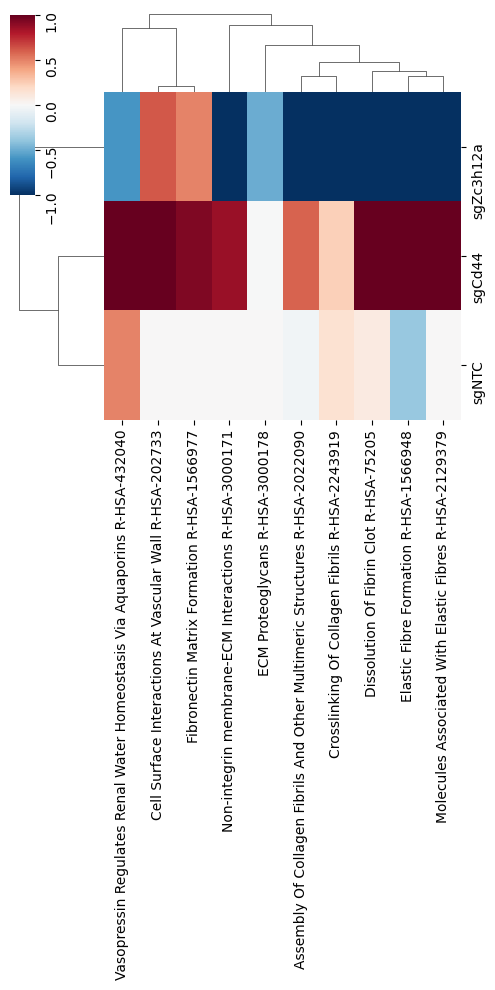

In [71]:
sns.clustermap(c_matrix.loc[["sgCd44", "sgZc3h12a", "sgNTC"], [("ECM" in name) or ("Vas" in name) or ("Fib" in name) for name in c_matrix.columns]], figsize=(5, 10), cmap="RdBu_r", vmax=1, vmin=-1, center=0)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.show()